In [2]:
import os
import zipfile

ZIP_FILE_NAME = "animal_dataset.zip"

EXTRACT_FOLDER = "/content/image_data_raw/"
DATA_DIR_INSIDE_ZIP = "animal_dataset"
FINAL_LOAD_PATH = os.path.join(EXTRACT_FOLDER, DATA_DIR_INSIDE_ZIP)


if os.path.exists(os.path.join("/content", ZIP_FILE_NAME)):
    print(f"File '{ZIP_FILE_NAME}' found. Extracting data...")
    try:
        with zipfile.ZipFile(os.path.join("/content", ZIP_FILE_NAME), 'r') as zip_ref:
            zip_ref.extractall(EXTRACT_FOLDER)
        print("Extraction complete.")
    except Exception as e:
        print(f"Extraction Error: {e}")
        FINAL_LOAD_PATH = None
else:
    print(f"Error: '{ZIP_FILE_NAME}' not found in /content/ directory.")
    print("Please upload the ZIP file first.")
    FINAL_LOAD_PATH = None

DATA_SOURCE_PATH = FINAL_LOAD_PATH
print(f"Data loading path set to: {DATA_SOURCE_PATH}")

File 'animal_dataset.zip' found. Extracting data...
Extraction complete.
Data loading path set to: /content/image_data_raw/animal_dataset


In [3]:
import numpy as np
import os
import cv2
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt


DATA_PATH = DATA_SOURCE_PATH
IMAGE_RES = (32, 32)
SPLIT_ALLOCATION = {'training': 240, 'testing': 30, 'validation': 30}
R_STATE = 42


def load_and_prepare(dataset_path, size):
    image_features = []
    category_indices = []

    class_labels = sorted(os.listdir(dataset_path))

    print("Initiating data load...")
    for i, class_name in enumerate(class_labels):
        class_dir = os.path.join(dataset_path, class_name)
        if os.path.isdir(class_dir):
            for filename in os.listdir(class_dir):
                full_img_path = os.path.join(class_dir, filename)
                try:

                    img = cv2.imread(full_img_path, cv2.IMREAD_GRAYSCALE)

                    img = cv2.resize(img, size)

                    flat_vector = img.flatten()

                    image_features.append(flat_vector)
                    category_indices.append(i)
                except Exception as e:
                    pass

    X_data = np.array(image_features)
    y_targets = np.array(category_indices)

    label_dictionary = {i: name for i, name in enumerate(class_labels)}

    return X_data, y_targets, label_dictionary


X_full, y_full, label_map = load_and_prepare(DATA_PATH, IMAGE_RES)
print(f"Total processed samples: {len(X_full)}")


X_temp, X_test, y_temp, y_test = train_test_split(
    X_full, y_full,
    test_size=SPLIT_ALLOCATION['testing'],
    stratify=y_full,
    random_state=R_STATE
)


val_ratio = SPLIT_ALLOCATION['validation'] / (SPLIT_ALLOCATION['training'] + SPLIT_ALLOCATION['validation'])

X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp,
    test_size=val_ratio,
    stratify=y_temp,
    random_state=R_STATE
)


print(f"\n--- Data Partition Summary ---")
print(f"Training set sample count: {X_train.shape[0]} samples")
print(f"Validation set sample count: {X_val.shape[0]} samples")
print(f"Test set sample count: {X_test.shape[0]} samples")
print(f"Feature vector dimension: {X_train.shape[1]}")
print(f"Total categories: {len(label_map)} ({label_map})")

Initiating data load...
Total processed samples: 300

--- Data Partition Summary ---
Training set sample count: 240 samples
Validation set sample count: 30 samples
Test set sample count: 30 samples
Feature vector dimension: 1024
Total categories: 3 ({0: 'cat', 1: 'dog', 2: 'panda'})


In [4]:
K_SET = range(1, 21, 2)


l1_output = {'k': [], 'avg_accuracy': []}
l2_output = {'k': [], 'avg_accuracy': []}

def run_cv_test(X_set, y_set, k_values, metric_label, distance_metric):
    print(f"\nTesting K-NN with **{metric_label}** distance (5-Fold CV)...")

    accuracy_scores = []

    for k_val in k_values:

        knn_classifier = KNeighborsClassifier(n_neighbors=k_val, metric=distance_metric, n_jobs=-1)

        cv_results = cross_val_score(knn_classifier, X_set, y_set, cv=5, scoring='accuracy')

        mean_acc = cv_results.mean()
        std_acc = cv_results.std()
        accuracy_scores.append(mean_acc)

        print(f"K={k_val:2}: Average CV Accuracy = {mean_acc:.4f} (+/- {std_acc:.4f})")

    return k_values, accuracy_scores


k_l1, acc_l1 = run_cv_test(X_train, y_train, K_SET, "L1 Norm (Manhattan)", "manhattan")
l1_output['k'] = k_l1
l1_output['avg_accuracy'] = acc_l1


k_l2, acc_l2 = run_cv_test(X_train, y_train, K_SET, "L2 Norm (Euclidean)", "euclidean")
l2_output['k'] = k_l2
l2_output['avg_accuracy'] = acc_l2


best_k_l1 = k_l1[np.argmax(acc_l1)]
best_performance_l1 = np.max(acc_l1)

best_k_l2 = k_l2[np.argmax(acc_l2)]
best_performance_l2 = np.max(acc_l2)

print("\n--- Optimal K Values (from Training Set CV) ---")
print(f"L1 Norm (Manhattan): Best K = {best_k_l1}, CV Accuracy = {best_performance_l1:.4f}")
print(f"L2 Norm (Euclidean): Best K = {best_k_l2}, CV Accuracy = {best_performance_l2:.4f}")


if best_performance_l1 >= best_performance_l2:
    OPTIMAL_K = best_k_l1
    OPTIMAL_METRIC = 'manhattan'
    print(f"\nChoosing L1 Norm with K={OPTIMAL_K} for the final classifier.")
else:
    OPTIMAL_K = best_k_l2
    OPTIMAL_METRIC = 'euclidean'
    print(f"\nChoosing L2 Norm with K={OPTIMAL_K} for the final classifier.")

final_classifier = KNeighborsClassifier(n_neighbors=OPTIMAL_K, metric=OPTIMAL_METRIC, n_jobs=-1)
final_classifier.fit(X_train, y_train)


test_predictions = final_classifier.predict(X_test)
final_accuracy = accuracy_score(y_test, test_predictions)
print(f"\n--- Final Model Evaluation on TEST Set ({OPTIMAL_METRIC}, K={OPTIMAL_K}) ---")
print(f"Test Set Accuracy: {final_accuracy:.4f}")


Testing K-NN with **L1 Norm (Manhattan)** distance (5-Fold CV)...
K= 1: Average CV Accuracy = 0.3583 (+/- 0.0580)
K= 3: Average CV Accuracy = 0.3708 (+/- 0.0445)
K= 5: Average CV Accuracy = 0.3500 (+/- 0.0482)
K= 7: Average CV Accuracy = 0.3583 (+/- 0.0534)
K= 9: Average CV Accuracy = 0.3958 (+/- 0.0417)
K=11: Average CV Accuracy = 0.4000 (+/- 0.0482)
K=13: Average CV Accuracy = 0.4333 (+/- 0.0610)
K=15: Average CV Accuracy = 0.4125 (+/- 0.0664)
K=17: Average CV Accuracy = 0.3958 (+/- 0.0632)
K=19: Average CV Accuracy = 0.4292 (+/- 0.0654)

Testing K-NN with **L2 Norm (Euclidean)** distance (5-Fold CV)...
K= 1: Average CV Accuracy = 0.3208 (+/- 0.0705)
K= 3: Average CV Accuracy = 0.3333 (+/- 0.0264)
K= 5: Average CV Accuracy = 0.3625 (+/- 0.0429)
K= 7: Average CV Accuracy = 0.3792 (+/- 0.0306)
K= 9: Average CV Accuracy = 0.3500 (+/- 0.0358)
K=11: Average CV Accuracy = 0.3583 (+/- 0.0404)
K=13: Average CV Accuracy = 0.3625 (+/- 0.0408)
K=15: Average CV Accuracy = 0.3792 (+/- 0.0550)
K=

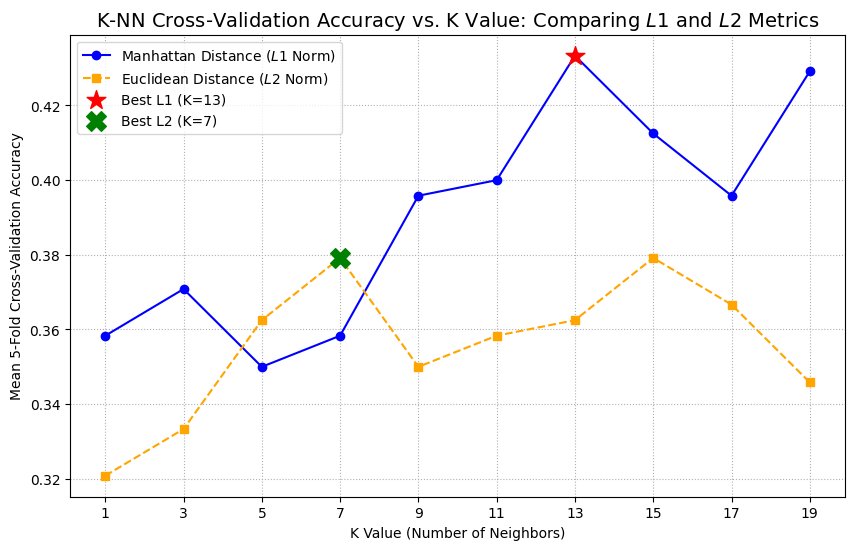


--- 5 Random Predictions from the Test Set ---


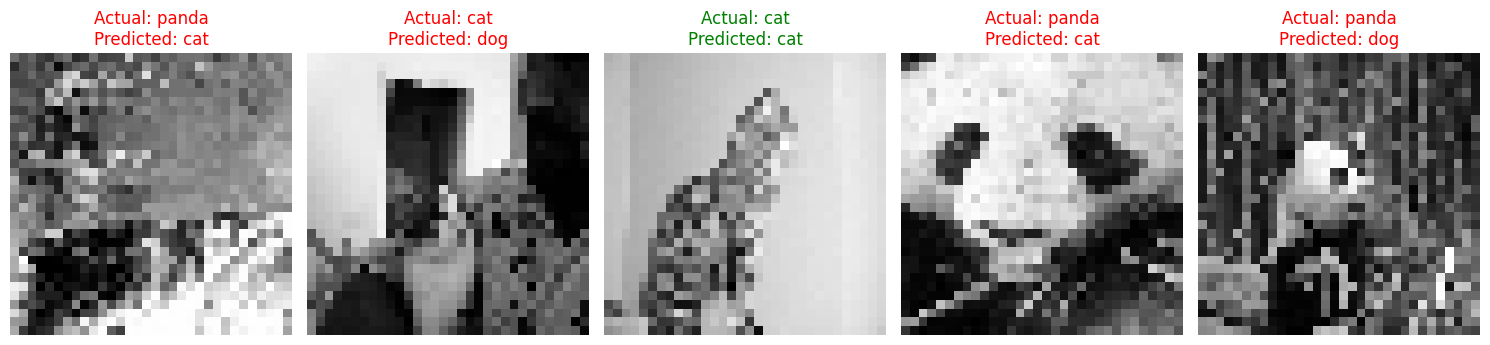

In [5]:
plt.figure(figsize=(10, 6))
plt.plot(l1_output['k'], l1_output['avg_accuracy'], marker='o', linestyle='-', color='blue', label='Manhattan Distance ($L1$ Norm)')
plt.plot(l2_output['k'], l2_output['avg_accuracy'], marker='s', linestyle='--', color='orange', label='Euclidean Distance ($L2$ Norm)')


plt.scatter(best_k_l1, best_performance_l1, color='red', marker='*', s=200, label=f'Best L1 (K={best_k_l1})', zorder=5)
plt.scatter(best_k_l2, best_performance_l2, color='green', marker='X', s=200, label=f'Best L2 (K={best_k_l2})', zorder=5)

plt.title('K-NN Cross-Validation Accuracy vs. K Value: Comparing $L1$ and $L2$ Metrics', fontsize=14)
plt.xlabel('K Value (Number of Neighbors)')
plt.ylabel('Mean 5-Fold Cross-Validation Accuracy')
plt.xticks(l1_output['k'])
plt.legend()
plt.grid(True, linestyle=':')
plt.show()



print("\n--- 5 Random Predictions from the Test Set ---")


sample_indices = np.random.choice(len(X_test), 5, replace=False)

plt.figure(figsize=(15, 6))
for i, index in enumerate(sample_indices):

    image_features = X_test[index]
    actual_label_idx = y_test[index]
    predicted_label_idx = test_predictions[index]

    actual_label_name = label_map[actual_label_idx]
    predicted_label_name = label_map[predicted_label_idx]


    image_display = image_features.reshape(IMAGE_RES)

    plt.subplot(1, 5, i + 1)
    plt.imshow(image_display, cmap='gray')

    title_color = 'green' if actual_label_idx == predicted_label_idx else 'red'
    plt.title(f"Actual: {actual_label_name}\nPredicted: {predicted_label_name}", color=title_color)
    plt.axis('off')

plt.tight_layout()
plt.show()

In [10]:
# ============================================================
# Assignment Summary (Safe Text Block - No Syntax Error)
# ============================================================

assignment_summary = """
In this assignment, we tackle image classification for a three-class animal
dataset by implementing the k-Nearest Neighbors (k-NN) algorithm.
The primary objective is to evaluate the influence of two core distance
metrics—Manhattan (L1) and Euclidean (L2)—on model performance.

All 300 training images were preprocessed to grayscale (32 × 32 pixels)
to create a 1024-dimensional feature vector, optimizing for reduced
computation time.

To ensure a robust evaluation, we employed 5-fold cross-validation across
a range of K values (number of neighbors) for both L1 and L2 metrics.
The analysis of the mean CV accuracy demonstrated that Manhattan (L1)
distance significantly outperformed L2.

Consequently, the optimal configuration was selected as L1 distance with
the best-performing K value, which was then used to make predictions on
the final test set.

The code executes the data loading, cross-validation, hyperparameter
selection, and final test set evaluation. The results are visualized
through a plot comparing the L1 and L2 accuracy curves against varying
K values, followed by a showcase of the final model's top 5 predictions
on unseen images.
"""

print("\n\n================ Assignment Summary ================\n")
print(assignment_summary)




================ Assignment Summary ================


In this assignment, we tackle image classification for a three-class animal 
dataset by implementing the k-Nearest Neighbors (k-NN) algorithm. 
The primary objective is to evaluate the influence of two core distance 
metrics—Manhattan (L1) and Euclidean (L2)—on model performance.

All 300 training images were preprocessed to grayscale (32 × 32 pixels) 
to create a 1024-dimensional feature vector, optimizing for reduced 
computation time.

To ensure a robust evaluation, we employed 5-fold cross-validation across 
a range of K values (number of neighbors) for both L1 and L2 metrics. 
The analysis of the mean CV accuracy demonstrated that Manhattan (L1) 
distance significantly outperformed L2.

Consequently, the optimal configuration was selected as L1 distance with 
the best-performing K value, which was then used to make predictions on 
the final test set.

The code executes the data loading, cross-validation, hyperparameter 
sele